In [1]:
import os
from typing import Dict

import numpy as np
import pandas as pd
import ray
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import TBXLoggerCallback
from ray.rllib.algorithms import AlgorithmConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.policy import Policy
import seaborn as sns

from stocktradingv2.agent.mydqn import MyDQNConfig, MyDQN
import stocktradingv2.env.SingleStockTradingEnv
from stocktradingv2.env.SingleStockTradingEnv import SingleStockTradingEnv

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init()

2023-03-05 16:37:47,024	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
dict_df = {}
for root, dirs, files in os.walk("./datasets/CSI300/"):
    for file in files:
        path = os.path.join("./datasets/CSI300/", file)
        df = pd.read_csv(path)
        dict_df[path] = df

In [4]:
i = 0
list_tic = list(dict_df.keys())
list_df = [dict_df[k] for k in list_tic]

0.9030076685093477


<AxesSubplot: ylabel='close_'>

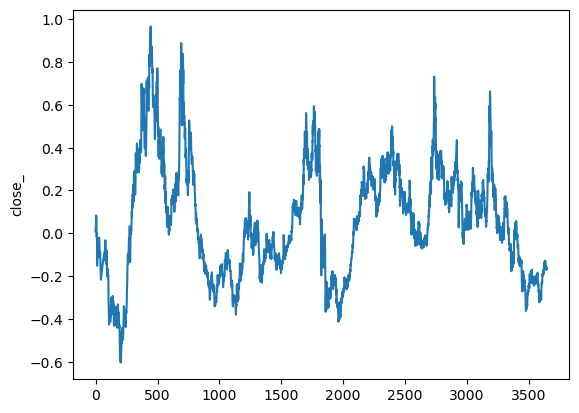

In [5]:
df = list_df[0]
df.rename(columns={"close_": "close", "close": "close_"}, inplace=True)
print(np.log(df.close.iloc[-1]/df.close.iloc[0]))
sns.lineplot(df.close_)

In [6]:
test_start = '2017-01-01'
trade_start = '2020-01-01'
test_start = pd.to_datetime(test_start, format='%Y-%m-%d')
trade_start = pd.to_datetime(trade_start, format='%Y-%m-%d')

df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df_train = df.loc[df.date < test_start].sort_index(ascending=True).copy()
df_test = df.loc[(df.date >= test_start) & (df.date < trade_start)].sort_index(ascending=True).copy()
df_trade = df.loc[df.date >= trade_start].sort_index(ascending=True).copy()

In [7]:

class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: Episode,
        env_index: int,
        **kwargs
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).
        assert episode.length <= 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        print("episode {} (env-idx={}) started.".format(episode.episode_id, env_index))

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: EpisodeV2,
        env_index: int,
        **kwargs
    ):
        env = base_env.get_sub_environments()[0]

        episode.custom_metrics["total_trading"] = env.total_trading
        episode.custom_metrics["success_trade"] = env.success_trade
        episode.custom_metrics["log-ret"] = np.log(env.asset_memory[-1] / env.asset_memory[0])
        # episode.hist_data["action_memory"] = env.action_memory
        # episode.hist_data["asset_memory"] = env.asset_memory

In [8]:
df_train

,date,open,high,low,close_,volume,cr-ma3,cci,cr-ma1,cr-ma2,change,ppoh,kdjj_9,ppo,ppos,stochrsi,close
0,2008-01-04,-0.011763,0.004979,0.001228,0.015123,-0.097496,59.200253,79.132081,59.200253,59.200253,2.821431,0.041180,57.768095,0.056785,0.015605,100.000000,4.126450
1,2008-01-07,0.010660,0.005028,0.011390,0.004635,0.243585,59.200253,79.270060,59.200253,59.200253,-0.879938,0.028985,62.664231,0.059439,0.030454,79.566951,4.090139
2,2008-01-08,0.003758,0.069019,0.014079,0.066334,1.163794,59.200253,166.666667,11.161591,59.200253,7.931315,0.238123,83.918891,0.369409,0.131285,100.000000,4.414541
3,2008-01-09,0.079465,0.083181,0.079241,0.083667,0.498500,59.200253,142.720595,23.686582,59.200253,3.354971,0.406087,97.499320,0.688375,0.282288,100.000000,4.562648
4,2008-01-10,0.081943,0.068964,0.077064,0.073716,-0.148958,59.200253,105.180170,35.056104,11.161591,0.314143,0.452597,104.341647,0.888233,0.435636,100.000000,4.576981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,2016-12-26,0.176213,0.161197,0.163753,0.169463,-0.383340,50.225470,-85.150679,-2.641891,28.398025,-1.382035,-0.690099,40.170978,-0.323819,0.366279,10.970448,4.123949
2184,2016-12-27,0.169022,0.170205,0.176582,0.182054,-0.585909,47.993783,-58.352688,-2.312359,18.445531,1.101121,-0.593653,55.699541,-0.375786,0.217866,29.174675,4.169358
2185,2016-12-28,0.182762,0.176986,0.192885,0.183123,-0.708826,45.419613,-22.821693,-0.090859,10.448570,0.098996,-0.497892,63.959284,-0.404499,0.093393,34.239280,4.173486
2186,2016-12-29,0.180342,0.172264,0.186837,0.184153,-0.644954,42.709142,-21.808087,2.325389,5.812886,0.098887,-0.406408,68.280135,-0.414617,-0.008209,68.243417,4.177613


In [10]:
param_space = {
    "framework": "torch",
    "env": "SingleStockTrading",
    "disable_env_checking": True,
    "env_config": {
        "df": df_train,
        # "verbose": True,
    },

    # "num_workers": 5,
    # "num_envs_per_worker": 10,
    # "num_cpus_per_worker": 1,

    "model": {
        "custom_model_config": {
            "type": tune.grid_search(["iqn", "cqn", "dqn", "qrdqn"]) ,
            "vmin": 0,
            "vmax": 100,
            "net_arch": [64],
            "action_mask_fn": SingleStockTradingEnv.action_mask_fn,
        }
    },

    #"min_sample_timesteps_per_iteration": 64,
    "min_train_timesteps_per_iteration": 64,
    
    "exploration_config": {
            "type": "EpsilonGreedy",
            "initial_epsilon": 1.0,
            "final_epsilon": 0.02,
            "epsilon_timesteps": 10000,
    },

    "evaluation_interval": 3,
    "evaluation_duration": 1,
    "evaluation_duration_unit": "episodes",
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "explore": False,
        "env_config": {
            "df": df_test,
        },
    }
}

In [11]:
tuner = tune.Tuner(
    MyDQN, 
    param_space=dict({"callbacks": MyCallbacks,}, **param_space),
    tune_config=tune.TuneConfig(num_samples=1),
    run_config=air.RunConfig(
        progress_reporter=JupyterNotebookReporter(),
        stop={
            "episode_reward_mean": 10,
            "timesteps_total": 10000,
        },
        callbacks=[TBXLoggerCallback()],
    )
    
)
results = tuner.fit()

In [14]:
results[0]

Result(metrics={'custom_metrics': {'total_trading_mean': 458.5, 'total_trading_min': 353, 'total_trading_max': 550, 'success_trade_mean': 240.5, 'success_trade_min': 202, 'success_trade_max': 278, 'log-ret_mean': 0.6739280269837461, 'log-ret_min': -0.5078911525914453, 'log-ret_max': 2.312917720073805}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.06978209316730499, 'cur_lr': 0.0005, 'td_error': 0.016889477148652077, 'loss': 0.003086389973759651, 'mean_r_t': 0.003764453111216426}, 'td_error': array([0.01688948], dtype=float32), 'mean_td_error': 0.016889477148652077, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 32.0, 'num_grad_updates_lifetime': 9002.0, 'diff_num_grad_updates_vs_sampler_policy': 2700.90625}}, 'num_env_steps_sampled': 10002, 'num_env_steps_trained': 288064, 'num_agent_steps_sampled': 10002, 'num_agent_steps_trained': 288064, 'last_target_update_ts': 10001, 'num_target_updates': 19

In [23]:
result = results.get_best_result(metric="episode_reward_mean", mode="max")

In [24]:
cp = result.best_checkpoints[0][0]

In [45]:
result

Result(metrics={'custom_metrics': {'total_trading_mean': 458.5, 'total_trading_min': 353, 'total_trading_max': 550, 'success_trade_mean': 240.5, 'success_trade_min': 202, 'success_trade_max': 278, 'log-ret_mean': 0.6739280269837461, 'log-ret_min': -0.5078911525914453, 'log-ret_max': 2.312917720073805}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.06978209316730499, 'cur_lr': 0.0005, 'td_error': 0.016889477148652077, 'loss': 0.003086389973759651, 'mean_r_t': 0.003764453111216426}, 'td_error': array([0.01688948], dtype=float32), 'mean_td_error': 0.016889477148652077, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 32.0, 'num_grad_updates_lifetime': 9002.0, 'diff_num_grad_updates_vs_sampler_policy': 2700.90625}}, 'num_env_steps_sampled': 10002, 'num_env_steps_trained': 288064, 'num_agent_steps_sampled': 10002, 'num_agent_steps_trained': 288064, 'last_target_update_ts': 10001, 'num_target_updates': 19

In [26]:
algo = MyDQN.from_checkpoint(cp)

2023-03-05 16:51:43,741	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
2023-03-05 16:51:43,777	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-05 16:51:47,744	WARNING util.py:67 -- Install gputil for GPU system monitoring.


In [36]:
env = SingleStockTradingEnv({"df": df_train})

In [37]:
obs, _ = env.reset()

In [38]:
obs

array([-1.17631157e-02,  4.97875621e-03,  1.22765430e-03,  1.51225299e-02,
       -9.74958485e-02,  5.92002531e+01,  7.91320811e+01,  5.92002531e+01,
        5.92002531e+01,  2.82143133e+00,  4.11800582e-02,  5.77680945e+01,
        5.67851353e-02,  1.56050772e-02,  1.00000000e+02,  0.00000000e+00])

In [28]:
pi = algo.get_policy() #.compute_single_action(obs[0])

In [29]:
np.log(df_test.close.iloc[-1] / df_test.close.iloc[0])

1.2828584199838469

In [27]:
algo.evaluate()

(RolloutWorker pid=9368) episode 80999052552010013 (env-idx=0) started.


{'evaluation': {'episode_reward_max': 0.4257228303669555,
  'episode_reward_min': 0.4257228303669555,
  'episode_reward_mean': 0.4257228303669555,
  'episode_len_mean': 730.0,
  'episode_media': {},
  'episodes_this_iter': 1,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {'total_trading_mean': 62.0,
   'total_trading_min': 62,
   'total_trading_max': 62,
   'success_trade_mean': 31.0,
   'success_trade_min': 31,
   'success_trade_max': 31,
   'log-ret_mean': 0.29508857956885637,
   'log-ret_min': 0.29508857956885637,
   'log-ret_max': 0.29508857956885637},
  'hist_stats': {'episode_reward': [0.4257228303669555],
   'episode_lengths': [730]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.3393860750420149,
   'mean_inference_ms': 1.476598340411519,
   'mean_action_processing_ms': 0.13359235510454295,
   'mean_env_wait_ms': 0.07882196502059331,
   'mean_env_render_ms': 0.0},
  'num_faulty_episodes': 0,
  'connector_metrics': {'O

(RolloutWorker pid=9368) episode 382150096101627407 (env-idx=0) started.


In [39]:
state = pi.model.get_initial_state()

In [41]:
import torch
from ray.rllib.policy.sample_batch import SampleBatch

In [42]:
obs = torch.tensor(obs)

In [ ]:
pi.model({SampleBatch.OBS: obs}, state, torch.tensor([1]))

In [ ]:
def get_envs(n_tickers: int = 10, seed=None) -> Tuple[MultiStockTradingEnv, MultiStockTradingEnv, MultiStockTradingEnv]:
    assert n_tickers <= len(df_dict_train)

    env_list = list()
    random.seed(seed)
    tic_list = random.sample(df_dict_train.keys(), n_tickers)
    print('Sampled tickers: ', tic_list)
    for _df_dict in [df_dict_train, df_dict_test, df_dict_trade]:
        if len(_df_dict[tic_list[0]]) == 0:
            env_list.append(None)
        else:
            _dfs = list()
            for tic in tic_list:
                _df = _df_dict[tic].copy()
                _df['tic'] = tic
                _dfs.append(_df)
            _dfs = pd.concat(_dfs)
            # drop dates that missing data
            _dfs = _dfs.pivot_table(index=['date'], columns=['tic']).dropna().stack().reset_index()
            _dfs.sort_values(['date', 'tic'], inplace=True)
            _dfs.set_index(['date', 'tic'], inplace=True)
            env_list.append(Monitor(MultiStockTradingEnv(_dfs, stack_frame=10)))
    
    return tuple(env_list)